In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src import config

In [2]:
df_og = pd.read_parquet(config.DATASET)

Initial shape of our dataset

In [3]:
df_og.shape

(3588295, 19)

All of our initial columns and their data types

In [4]:
for column in df_og.columns:
    print(column, df_og[column].dtype)

VendorID int64
tpep_pickup_datetime datetime64[us]
tpep_dropoff_datetime datetime64[us]
passenger_count float64
trip_distance float64
RatecodeID float64
store_and_fwd_flag object
PULocationID int64
DOLocationID int64
payment_type int64
fare_amount float64
extra float64
mta_tax float64
tip_amount float64
tolls_amount float64
improvement_surcharge float64
total_amount float64
congestion_surcharge float64
airport_fee float64


Some records to see how our data looks

In [5]:
df_og.head(5).T

,0,1,2,3,4
VendorID,1,1,1,1,1
tpep_pickup_datetime,2022-05-01 00:00:36,2022-05-01 00:27:44,2022-05-01 00:59:00,2022-05-01 00:48:18,2022-05-01 00:28:26
tpep_dropoff_datetime,2022-05-01 00:19:18,2022-05-01 00:41:33,2022-05-01 01:14:22,2022-05-01 01:28:02,2022-05-01 00:37:49
passenger_count,1.0,1.0,1.0,1.0,1.0
trip_distance,4.1,2.3,4.2,0.0,1.6
RatecodeID,1.0,1.0,1.0,1.0,1.0
store_and_fwd_flag,N,N,N,N,N
PULocationID,246,238,163,79,238
DOLocationID,151,74,260,182,75
payment_type,2,2,2,1,1


In [6]:
df_og['VendorID'].min()

1

First we will count how many missing values to we have on each column

In [7]:
# count the missing values per columns, and the percentage that they represent against the total amount of rows available
filt_missing = df_og.isnull().sum()
df_missing_percent = filt_missing.sort_values(ascending=False).to_frame().rename(columns={0:'Total'})
df_missing_percent['Percent'] = (df_missing_percent/df_og.shape[0])*100
df_missing_percent['Percent'] = df_missing_percent['Percent'].round(2)
df_missing_percent

,Total,Percent
airport_fee,129524,3.61
congestion_surcharge,129524,3.61
passenger_count,129524,3.61
RatecodeID,129524,3.61
store_and_fwd_flag,129524,3.61
extra,0,0.00
total_amount,0,0.00
improvement_surcharge,0,0.00
tolls_amount,0,0.00
tip_amount,0,0.00


The missing values represent a very small amount from the total amount of records that we have available, so dropping them from out dataframe will not affect our process

In [8]:
df_og.dropna(inplace=True)

# our new shape becomes
df_og.shape

(3458771, 19)

Distribution of target variables

In [9]:
# first the distribution of the fare_amount variable
# we will only be using a subset of our dataset since it is too big
sample = df_og.sample(frac=0.05, random_state=42)

In [10]:
fares = sample['fare_amount'].to_numpy()

In [11]:
# min and max amounts
print(f'Max amount in fares: {fares.max()}')
print(f'Min amount in fares: {fares.min()}')

Max amount in fares: 480.0
Min amount in fares: -900.0


We see that we have some clear outliers, such as negative numbers (which should not be possible, so we will have to remove them most likely)

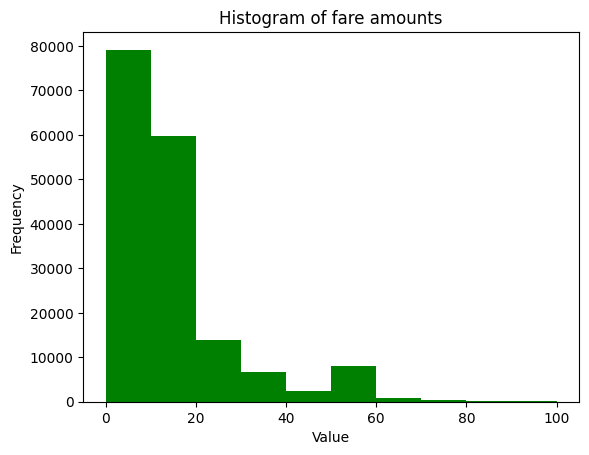

In [12]:
plt.hist(fares,bins=[0,10,20,30,40,50,60,70,80,90,100],color='green')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of fare amounts')
plt.show()

It is clear that the grand majority of fares will be concentrated between 0 and 20

In [13]:
# how many records include a fare amount that is less than 0 (i.e negative values)
# this is taken from our original df
df_og[df_og['fare_amount'] < 0].count()

VendorID                 20471
tpep_pickup_datetime     20471
tpep_dropoff_datetime    20471
passenger_count          20471
trip_distance            20471
RatecodeID               20471
store_and_fwd_flag       20471
PULocationID             20471
DOLocationID             20471
payment_type             20471
fare_amount              20471
extra                    20471
mta_tax                  20471
tip_amount               20471
tolls_amount             20471
improvement_surcharge    20471
total_amount             20471
congestion_surcharge     20471
airport_fee              20471
dtype: int64

So we have a total of 20,471 records that include a fare amount that is negative, we can safely remove this because they represent such a small amount when compared to the total number of records as well

In [14]:
idx_to_drop = df_og[df_og['fare_amount'] < 0].index
df_og.drop(idx_to_drop, inplace=True)

# new shape after dropping negative fare values
df_og.shape

(3438300, 19)

Now we can plot the same info for travel times, to see how the distributions of those look

In [15]:
# First we need to calculate the travel time in seconds for each travel record that we have
df_og['travel_time'] = df_og['tpep_dropoff_datetime'] - df_og['tpep_pickup_datetime']
df_og['travel_time'] = df_og['travel_time'].dt.total_seconds()

In [16]:
sample_travel = df_og.sample(frac=0.05, random_state=42)
travel_times = sample_travel['travel_time'].to_numpy()

In [17]:
# min and max amounts
print(f'Max amount in travel times: {travel_times.max()}')
print(f'Min amount in travel times: {travel_times.min()}')

Max amount in travel times: 409413.0
Min amount in travel times: 0.0


In [18]:
# top then travel time values
travel_times[np.argpartition(travel_times, -400)[-400:]]

array([  6152.,   6153.,   6161.,   6155.,   6162.,   6635.,   6524.,
         6190.,   6614.,   6376.,   6576.,   6614.,   6229.,   6339.,
         6624.,   6503.,   6334.,   6375.,   6317.,   6192.,   6194.,
         6344.,   6528.,   6331.,   6262.,   6356.,   6340.,   6317.,
         6469.,   6224.,   6296.,   6433.,   6626.,   6652.,   6347.,
         6172.,   6178.,   6420.,   6287.,   6525.,   6177.,   6595.,
         6302.,   6264.,   6415.,   6380.,   6648.,   6291.,   6373.,
         6357.,   6239.,   6565.,   6182.,   6475.,   6351.,   6693.,
         6778.,   7230.,   6757.,   6846.,   7061.,   6975.,   6821.,
         6974.,   6859.,   7135.,   6838.,   6895.,   6868.,   6797.,
         7009.,   7109.,   6926.,   7001.,   7276.,   6854.,   7203.,
         6769.,   7263.,   6899.,   7178.,   6949.,   7254.,   7146.,
         6726.,   6722.,   6816.,   6894.,   6824.,   7212.,   6774.,
         7165.,   6772.,   7306.,   8046.,  49509.,  11199.,   8184.,
        82694.,   97

We can see some clear outliers, most of those are values orbiting around 86000s which is the equivalent to 24hrs, indicating clear incorrect inputs.
We will remove any records with a travel time above 18,000s (around 5 hours)

In [19]:
# removing the rows with travel times above 24hrs
idx_travel_time = df_og[df_og['travel_time'] > 18000].index
df_og.drop(idx_travel_time, inplace=True)
df_og.shape

(3433452, 20)

There is some really extensive travel times, so we will have to take that into account to detect outliers

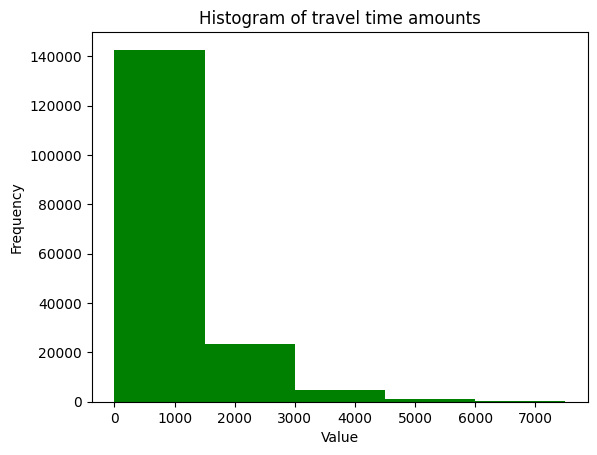

In [20]:
plt.hist(travel_times,bins=[0,1500,3000,4500,6000,7500],color='green')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of travel time amounts')
plt.show()

the majority of our travel times are between 0 and 2000s

Also, we can see what the taxi zone codes mean from another file

In [21]:
zones = pd.read_csv(config.DATASET_ZONE_DESCRIPTIONS)

In [22]:
zones

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


given this, it will probably be useful to also drop all the rows that contain 264 or 265 as code values, since we would not be able to draw much significant information from them for now

In [23]:
removal = (df_og['DOLocationID'] == 264) | (df_og['DOLocationID'] == 265) | (df_og['PULocationID'] == 264) | (df_og['PULocationID'] == 265)
df_og = df_og[~removal]
df_og.shape

(3376508, 20)

Finally we can look at the zones to determine the distance between the centroids, and add that as a new column

In [24]:
import geopandas as gp

In [25]:
gdf = gp.read_file(config.DATASET_ZONE_GEOM)

In [26]:
gdf['centroids'] = gdf.centroid
gdf = gdf.to_crs('EPSG:32618')

In [27]:
# we could calculate the distance between two centroids like so
distance = gdf['centroids'].iloc[262].distance(gdf['centroids'].iloc[261])
distance

1618.2387894829762

In [28]:
# we can also include a new categorical column called 'time_of_day' to stablish whether a trip ocurred in the
# morning, afternoon, or at night
def period_of_time(dt:pd.Timestamp):
    if dt.hour <= 7 or dt.hour >= 20:
        return 'night'
    elif dt.hour > 7 and dt.hour < 12:
        return 'morning'
    else:
        return 'afternoon'

df_og['time_of_day'] = df_og['tpep_pickup_datetime'].apply(period_of_time)

In [29]:
df_og.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,travel_time,time_of_day
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,4.1,1.0,N,246,151,2,...,3.0,0.5,0.0,0.0,0.3,20.8,2.5,0.0,1122.0,night
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,2.3,1.0,N,238,74,2,...,3.0,0.5,0.0,0.0,0.3,14.8,2.5,0.0,829.0,night
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,4.2,1.0,N,163,260,2,...,3.0,0.5,0.0,0.0,0.3,19.3,2.5,0.0,922.0,night


In [30]:
# adding new column to indicate the day of the month that it was
# also another one to indicate whether the trip took place on a weekend or not
df_og['day'] = df_og['tpep_dropoff_datetime'].dt.day
df_og['month'] = df_og['tpep_dropoff_datetime'].dt.month

def is_weekend(dt:pd.Timestamp):
    if dt.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        return 1
    else:
        return 0
df_og['is_weekend'] = df_og['tpep_dropoff_datetime'].apply(is_weekend)

In [31]:
# now we add another column that includes the distance between cetroids
def dist_between_zones(row):
    pu = int(row['PULocationID'])
    do = int(row['DOLocationID'])

    return gdf['centroids'].iloc[pu-1].distance(gdf['centroids'].iloc[do-1])

In [32]:
type(df_og[['time_of_day', 'PULocationID']])

pandas.core.frame.DataFrame

In [33]:
df_og['distance_between_zones'] = df_og.apply(dist_between_zones,axis=1)

In [34]:
# convert distances to miles (they are originally in meters)

df_og['distance_between_zones'] = df_og['distance_between_zones']*0.000621371

In [35]:
# we can then drop all the unnecessary columns from our dataset

df_og.drop(columns=['VendorID','tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count',
                   'RatecodeID','store_and_fwd_flag','payment_type','extra',
                   'mta_tax','tip_amount','tolls_amount','total_amount'],inplace=True)

In [36]:
df_og.isna().sum()

trip_distance             0
PULocationID              0
DOLocationID              0
fare_amount               0
improvement_surcharge     0
congestion_surcharge      0
airport_fee               0
travel_time               0
time_of_day               0
day                       0
month                     0
is_weekend                0
distance_between_zones    0
dtype: int64